In [289]:
import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import loadtxt
from keras import backend as K
from scikeras.wrappers import KerasRegressor
import time
from sklearn.metrics import make_scorer
from matplotlib import pyplot as plt
import datetime
import csv
from sklearn.model_selection import ParameterGrid, KFold

In [290]:

# Load training data from CSV, excluding 1st and last 3 cols
def read_tr(file_path, test_size=0.15, random_state=42):
    # load tr data
    train = loadtxt(file_path, delimiter=',', usecols=range(1, 14), dtype=np.float64)


    x = train[:, :-3]  # Exclude 1st col and keep the last 3 as targets
    y = train[:, -3:]  # targets

    # Split the dataset 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)


    return x_train, y_train, x_test, y_test

# read TS data
def read_ts():
    # path
    file = "./cup/ds/ML-CUP23-TS.csv"
    test = loadtxt(file, delimiter=',', usecols=range(1, 11), dtype=np.float64)

    return test

# MEE for CUP
def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# Get the mean value of all the passed losses
def euclidean_distance_score(y_true, y_pred):
    return np.mean(euclidean_distance_loss(y_true, y_pred))

scorer = make_scorer(euclidean_distance_score, greater_is_better=False)


# define the NN model
def create_model(layers=3, n_units=200, init_mode='glorot_normal',activation='relu', lmb=0.005, eta=0.004, alpha=0.08, batch_size=None): #relu
    model = Sequential() #sequential model, linear stack of layers
    
    # create hidden layers with tanh activation
    for i in range(layers - 1):  # Last layer will have ReLU activation
        model.add(Dense(n_units, kernel_initializer=init_mode, activation=activation, kernel_regularizer=l2(lmb)))
    
    # create output layer with linear activation for regession task
    model.add(Dense(3, kernel_initializer=init_mode, activation='linear'))

    # use SGD optimizer
    optimizer = SGD(learning_rate=eta, momentum=alpha)
    
    # Compile the model with mean_euclidean_error as the loss function and metric
    model.compile(optimizer=optimizer, loss=euclidean_distance_loss, metrics=[euclidean_distance_loss])
    
    return model


# save results for the CUP
def save_predictions_to_csv(file_path, y_pred):
    # Generate timestamp for the date
    timestamp = datetime.datetime.now().strftime("%d %b %Y")

    # Write informations to the CSV file
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerow(['Franceschi Andrea - Marco Del Pistoia - Francesco Longobardi'])
        writer.writerow(['FraDeLo']) 
        writer.writerow(['ML-CUP23 v1'])
        writer.writerow([f'date ({timestamp})'])

    # Write predictions to the CSV file
    with open(file_path, mode='a', newline='') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerow(['id', 'output_x', 'output_y', 'output_z'])
        for i, row in enumerate(y_pred):
            writer.writerow([i + 1] + list(row))

In [291]:
def model_selection(x, y, epochs=300, k_fold=10):
    param_grid = {
        'lmb':[0.002, 0.01, 0.03],
        'eta': [0.00125, 0.001, 0.002],
        'alpha': [0.8, 0.9, 0.95],
        'batch_size': [64, 110, 128]
    }

    param_combinations = list(ParameterGrid(param_grid))

    best_params = None
    best_loss = float('inf')  # initialize best loss with highest possible value

    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)

    for params in param_combinations:
        val_losses = []

        for train_index, val_index in kf.split(x):
            x_train, x_val = x[train_index], x[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Create a neural network model with the specified parameters
            model = create_model(layers=3, **params)

            # Train the model on the training data (x_train, y_train) with validation data (x_val, y_val)
            history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=params['batch_size'], verbose=0)

            # Calculate the final loss on the validation set
            val_loss = history.history['val_loss'][-1]
            val_losses.append(val_loss)

        # Calculate the mean validation loss over k folds
        mean_val_loss = np.mean(val_losses)

        # Print mean validation loss for each parameter combination
        print(f"\nParameters: {params}")
        print(f"Mean Validation Loss: {mean_val_loss:.4f}")

        # Update the best loss and corresponding hyperparameters if necessary
        if mean_val_loss < best_loss:
            best_loss = mean_val_loss
            best_params = params

    # Print the best hyperparameters and corresponding scores
    print("\nBest Parameters:", best_params)
    print("Best Mean Validation Loss:", best_loss)

    return best_params



Grid search results:
Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.5364

Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 2.1638

Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 2.7154

Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.5557

Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 2.3543

Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 2.8756

Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.4405

Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 1.9773

Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 2.6274

Parameters: {'alpha': 0.9, 'batch_size': 110, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.6762

Parameters: {'alpha': 0.9, 'batch_size': 110, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 2.7117

Parameters: {'alpha': 0.9, 'batch_size': 110, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 3.2431

Parameters: {'alpha': 0.9, 'batch_size': 110, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.7861

Parameters: {'alpha': 0.9, 'batch_size': 110, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 2.9735

Parameters: {'alpha': 0.9, 'batch_size': 110, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 3.5865

Parameters: {'alpha': 0.9, 'batch_size': 110, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.5756

Parameters: {'alpha': 0.9, 'batch_size': 110, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 2.2754

Parameters: {'alpha': 0.9, 'batch_size': 110, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 2.7746

Parameters: {'alpha': 0.9, 'batch_size': 128, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.7639

Parameters: {'alpha': 0.9, 'batch_size': 128, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 2.8846

Parameters: {'alpha': 0.9, 'batch_size': 128, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 3.4734

Parameters: {'alpha': 0.9, 'batch_size': 128, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.8797

Parameters: {'alpha': 0.9, 'batch_size': 128, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 3.1597

Parameters: {'alpha': 0.9, 'batch_size': 128, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 3.9246

Parameters: {'alpha': 0.9, 'batch_size': 128, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.6593

Parameters: {'alpha': 0.9, 'batch_size': 128, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 2.4068

Parameters: {'alpha': 0.9, 'batch_size': 128, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 2.9151

Parameters: {'alpha': 0.8, 'batch_size': 64, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.7405

Parameters: {'alpha': 0.8, 'batch_size': 64, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 2.8811

Parameters: {'alpha': 0.8, 'batch_size': 64, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 3.4558

Parameters: {'alpha': 0.8, 'batch_size': 64, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.8506

Parameters: {'alpha': 0.8, 'batch_size': 64, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 3.1388

Parameters: {'alpha': 0.8, 'batch_size': 64, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 3.9325

Parameters: {'alpha': 0.8, 'batch_size': 64, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.6276

Parameters: {'alpha': 0.8, 'batch_size': 64, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 2.4043

Parameters: {'alpha': 0.8, 'batch_size': 64, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 2.9115

Parameters: {'alpha': 0.8, 'batch_size': 110, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 2.0665

Parameters: {'alpha': 0.8, 'batch_size': 110, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 3.5569

Parameters: {'alpha': 0.8, 'batch_size': 110, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 4.7512

Parameters: {'alpha': 0.8, 'batch_size': 110, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 2.2676

Parameters: {'alpha': 0.8, 'batch_size': 110, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 3.8705

Parameters: {'alpha': 0.8, 'batch_size': 110, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 5.4183

Parameters: {'alpha': 0.8, 'batch_size': 110, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.7949

Parameters: {'alpha': 0.8, 'batch_size': 110, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 3.0045

Parameters: {'alpha': 0.8, 'batch_size': 110, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 3.6396

Parameters: {'alpha': 0.8, 'batch_size': 128, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 2.2386

Parameters: {'alpha': 0.8, 'batch_size': 128, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 3.7801

Parameters: {'alpha': 0.8, 'batch_size': 128, 'eta': 0.00125, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 5.2028

Parameters: {'alpha': 0.8, 'batch_size': 128, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 2.4481

Parameters: {'alpha': 0.8, 'batch_size': 128, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 4.1036

Parameters: {'alpha': 0.8, 'batch_size': 128, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 5.9571

Parameters: {'alpha': 0.8, 'batch_size': 128, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Mean Validation Loss: 1.8880

Parameters: {'alpha': 0.8, 'batch_size': 128, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.01}
Mean Validation Loss: 3.1685

Parameters: {'alpha': 0.8, 'batch_size': 128, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.03}
Mean Validation Loss: 3.9081

Best Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.002}
Best Mean Validation Loss: 1.4405151963233949

In [292]:
def predict(model, x_ts, x_its, y_its):
    # predict on internal test set
    y_ipred = model.predict(x_its)
    # evaluate loss with MEE
    iloss = euclidean_distance_loss(y_its,y_ipred) 
  
    y_pred = model.predict(x_ts)

    return y_pred, K.eval(iloss)

In [293]:

def plot_learning_curve(history, start_epoch=1, **kwargs):
    lgd = ['Loss TR']
    plt.plot(range(start_epoch, kwargs['epochs']), history['loss'][start_epoch:])
    
    if "val_loss" in history:
        plt.plot(range(start_epoch, kwargs['epochs']), history['val_loss'][start_epoch:])
        lgd.append('Loss VL')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f'Keras Learning Curve \n {kwargs}')
    plt.legend(lgd)

    # Check if predictions are available in the history
    if 'predictions' in history:
        predictions = history['predictions']
        
        # Plot predictions for each variable
        for i in range(predictions.shape[1]):
            plt.figure()
            plt.plot(range(start_epoch, kwargs['epochs']), predictions[:, i][start_epoch:])
            plt.xlabel("Epoch")
            plt.ylabel(f"Prediction Variable {i+1}")
            plt.title(f'Keras Learning Curve \n {kwargs} - Prediction Variable {i+1}')
    
    plt.show()


In [294]:

def keras_nn(ms=False, output_file='FraDeLo_ML-CUP23-TS.csv'):
    print("keras start")

    file_path_tr = "./cup/ds/ML-CUP23-TR.csv"
    
    # read training set
    x, y, x_its, y_its = read_tr(file_path_tr)

    # choose model selection or hand-given parameters
    if ms:
        params = model_selection(x, y, epochs=300, k_fold=10)
    else:
        params = dict(eta=0.00125, alpha=0.9, lmb=0.002, epochs=310, batch_size=110) 
    '''
    Best Parameters: {'alpha': 0.9, 'batch_size': 64, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.002}
    Best Mean Validation Loss: 1.4405151963233949
    '''
    #params = dict(eta=0.00125, alpha=0.9, lmb=0.002, epochs=310, batch_size=110)

    # create and fit the model
    model = create_model(eta=params['eta'], alpha=params['alpha'], lmb=params['lmb'])
      
    start_train_time = time.time()  # Record the starting time of the training
    res = model.fit(x, y, validation_split=0.3, epochs=params['epochs'], batch_size=params['batch_size'], verbose=1)
    end_train_time = time.time()

    tr_losses = res.history['loss']
    val_losses = res.history['val_loss']
    
    
    # Predict for the three variables
    y_pred, ts_losses = predict(model=model, x_ts=read_ts(), x_its=x_its, y_its=y_its)
    
    # Save predictions to CSV
    #save_predictions_to_csv(output_file, y_pred)
    
    
    print("TR Loss: ", tr_losses[-1])
    print("VL Loss: ", val_losses[-1])
    print("TS Loss: ", np.mean(ts_losses))
    
    training_time = end_train_time - start_train_time
    print("Training Time: {:.2f} seconds".format(training_time))

    print("keras end")
    print(y_pred)

    plot_learning_curve(res.history, **params)
    

# NN with Early stopping
run the model for 1000 epochs: we got problems to plot the training curve, no problem: this function give us the # of epochs for which we got no improvements (after 10 epochs), so is commented and the correct # epochs is given to the previous function: 
 results: 
6/6 [==============================] - 0s 7ms/step - loss: 1.5641 - euclidean_distance_loss: 1.0462 - val_loss: 1.8281 - val_euclidean_distance_loss: 1.3104
Epoch 308: early stopping
5/5 [==============================] - 0s 987us/step
29/29 [==============================] - 0s 889us/step
Structure of y_pred: [[  9.083963     9.398766    19.813477  ]
 [  8.494265   -37.580475    34.374172  ]
 [  9.412038     5.764892    20.003586  ]
 ...
 [  5.4391093    9.902451     0.24009445]
 [  3.7351596  -69.34859     28.1709    ]
 [-69.03668      5.9125805   11.810619  ]]
TR Loss:  1.5640722513198853
VL Loss:  1.8281021118164062
TS Loss:  1.3520365953445435
Training Time: 10.98 seconds
keras end

so run the model with 310 epochs

In [295]:

from keras.callbacks import EarlyStopping

def keras_nn_es(ms=False, output_file='FraDeLo_ML-CUP23-TS.csv'):
    print("keras start")

    file_path_tr = "./cup/ds/ML-CUP23-TR.csv"
    
    # read training set
    x, y, x_its, y_its = read_tr(file_path_tr)

    # choose model selection or hand-given parameters
    if ms:
        params = model_selection(x, y)
    else:
        params = dict(eta=0.00125, alpha=0.9, lmb=0.002, epochs=1000, batch_size=110)

    # create and fit the model
    model = create_model(eta=params['eta'], alpha=params['alpha'], lmb=params['lmb'])
    
    #introduce early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    
    start_train_time = time.time()  # Record the starting time of the training
    res = model.fit(x, y, validation_split=0.3, epochs=params['epochs'], batch_size=params['batch_size'], verbose=1, callbacks=[es])
    end_train_time = time.time()

    tr_losses = res.history['loss']
    val_losses = res.history['val_loss']
    
    
    # Predict for the three variables
    y_pred, ts_losses = predict(model=model, x_ts=read_ts(), x_its=x_its, y_its=y_its)
    
    # Print the structure of y_pred
    print("Structure of y_pred:", y_pred)
    
    # Save predictions to CSV
    save_predictions_to_csv(output_file, y_pred)
    

    print("TR Loss: ", tr_losses[-1])
    print("VL Loss: ", val_losses[-1])
    print("TS Loss: ", np.mean(ts_losses))
    
    training_time = end_train_time - start_train_time
    print("Training Time: {:.2f} seconds".format(training_time))
    print("keras end")
    plot_learning_curve(res.history, savefig=True, **params)
    

keras start
Epoch 1/310


6/6 [==============================] - 0s 28ms/step - loss: 43.2422 - euclidean_distance_loss: 42.8023 - val_loss: 43.3316 - val_euclidean_distance_loss: 42.8917
Epoch 2/310
6/6 [==============================] - 0s 6ms/step - loss: 43.1471 - euclidean_distance_loss: 42.7073 - val_loss: 43.1897 - val_euclidean_distance_loss: 42.7500
Epoch 3/310
6/6 [==============================] - 0s 6ms/step - loss: 42.9940 - euclidean_distance_loss: 42.5543 - val_loss: 43.0119 - val_euclidean_distance_loss: 42.5724
Epoch 4/310
6/6 [==============================] - 0s 6ms/step - loss: 42.8142 - euclidean_distance_loss: 42.3747 - val_loss: 42.8129 - val_euclidean_distance_loss: 42.3735
Epoch 5/310
6/6 [==============================] - 0s 7ms/step - loss: 42.6149 - euclidean_distance_loss: 42.1755 - val_loss: 42.5988 - val_euclidean_distance_loss: 42.1594
Epoch 6/310
6/6 [==============================] - 0s 6ms/step - loss: 42.4036 - euclidean_distance_loss: 41.9643 - val_loss: 42.3684 - val_euclid

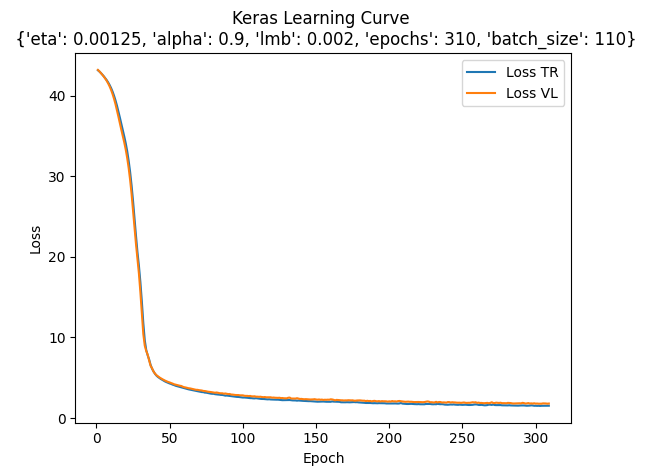

In [296]:
keras_nn()